In [2]:
%matplotlib inline

Analyze MIBI-TOF image data
===========================

This tutorial shows how to apply Squidpy to MIBI-TOF data.

The data used here comes from a recent paper from {cite}`hartmann2020multiplexed`.
We provide a pre-processed subset of the data, in :class:`anndata.AnnData` format.
For details on how it was pre-processed, please refer to the original paper.


Import packages & data
----------------------
To run the notebook locally, create a conda environment as *conda env create -f environment.yml* using this
`environment.yml <https://github.com/scverse/squidpy_notebooks/blob/main/environment.yml>`_.

In [3]:
import squidpy as sq

import numpy as np

import matplotlib.pyplot as plt

adata = sq.datasets.mibitof()

The subset of the data we consider here comprises three biopsies colorectal carcinoma biopsies
from different donors, where MIBI-TOF was used to measure single-cell metabolic profiles.
As imaging information, we included three raw image channels:

  - `145_CD45` - a immune cell marker (cyan).
  - `174_CK` - a tumor marker (magenta).
  - `113_vimentin` - a mesenchymal cell marker (yellow).

and a cell segmentation mask provided by the authors of the original paper.

The `adata` object contains three different libraries, one for each biopsy.
The images are contained in ``adata.uns['spatial'][<library_id>]['images']``.
Let us visualize the cluster annotations for each library using {func}`squidpy.pl.spatial_scatter`.

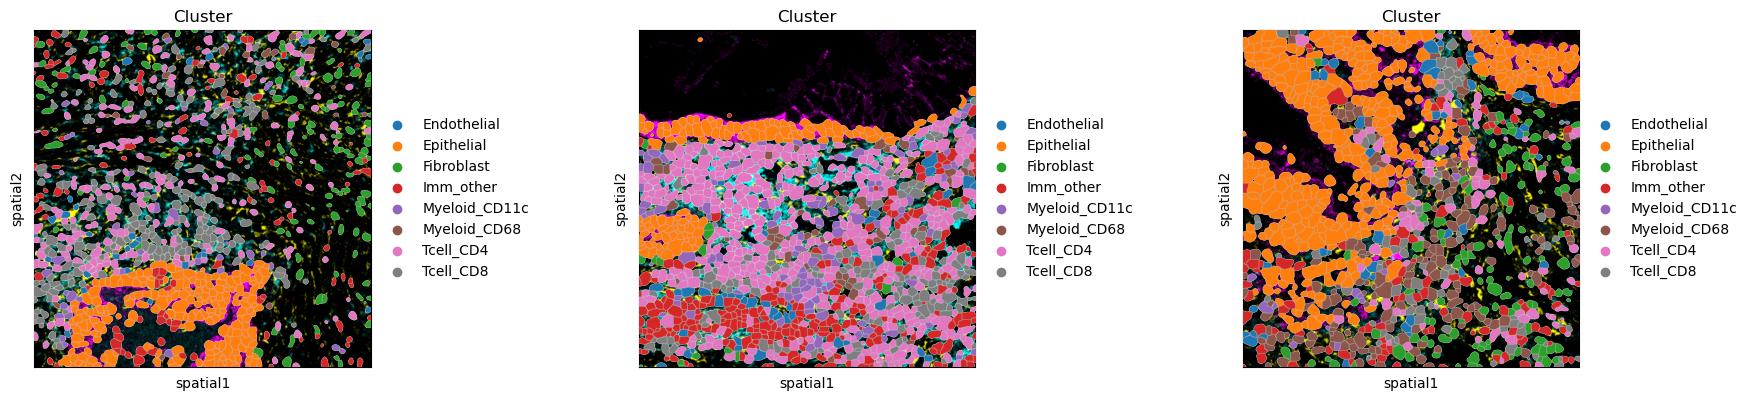

In [4]:
sq.pl.spatial_segment(adata, color="Cluster", library_key="library_id", seg_cell_id="cell_id")

Let us create an ImageContainer from the images contained in `adata`.
As all three biopsies are already joined in `adata`, let us also create one ImageContainer for
all three biopsies using a z-stack.
For more information on how to use `ImageContainer` with z-stacks, also have a look at
{doc}`tutorials/tutorial_image_container_zstacks.py`.

In [5]:
imgs = []
for library_id in adata.uns["spatial"].keys():
    img = sq.im.ImageContainer(adata.uns["spatial"][library_id]["images"]["hires"], library_id=library_id)
    img.add_img(adata.uns["spatial"][library_id]["images"]["segmentation"], library_id=library_id, layer="segmentation")
    img["segmentation"].attrs["segmentation"] = True
    imgs.append(img)
img = sq.im.ImageContainer.concat(imgs)

Note that we also added the segmentation as an additional layer to `img`, and set the
`segmentation` attribute in the ImageContainer.
This allows visualization of the segmentation layer as a `labels` layer in Napari.

In [6]:
img

ImageContainer[shape=(1024, 1024), layers=['image', 'segmentation']]

If you have Napari installed, you can have a look at the data using the interactive viewer:
Note that you can load the segmentation layer as an overlay over the image.

.. code-block:: python

    img.interactive(adata, library_key='library_id')

Let us also statically visualize the data in `img`, using {func}`squidpy.im.ImageCntainer.show`:

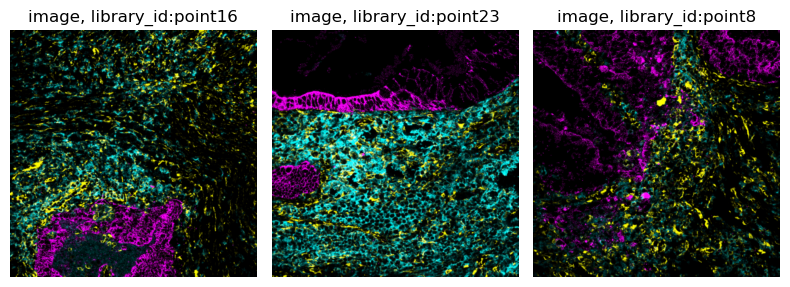

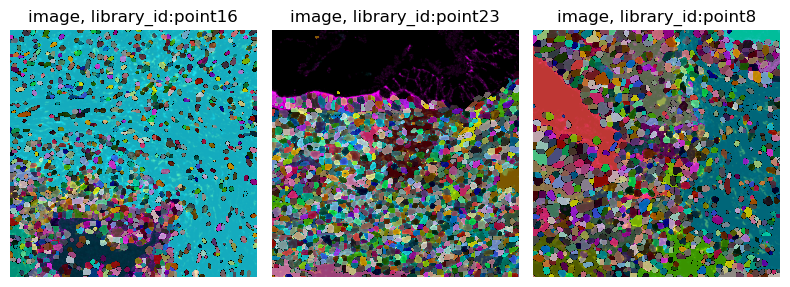

In [7]:
img.show("image")
img.show("image", segmentation_layer="segmentation")

In the following we show how to use Squidpy to extract cellular mean intensity information using raw images
and a provided segmentation mask.
In the present case, `adata` of course already contains the post-processed cellular mean intensity
for the raw image channels.
The aim of this tutorial, however, is to showcase how the extraction of such features is possible using Squidpy.
As Squidpy is backed by {mod}`dask` and supports chunked image processing,
also large images can be processed in this way.

Convert image to CMYK
---------------------
As already mentioned, the images contain information from three raw channels, `145_CD45`,
`174_CK`, and `113_vimentin`.
As the channel information is encoded in CMYK space, we first need to convert the RGB images to CMYK.

For this, we can use {meth}`squidpy.im.ImageContainer.apply`.

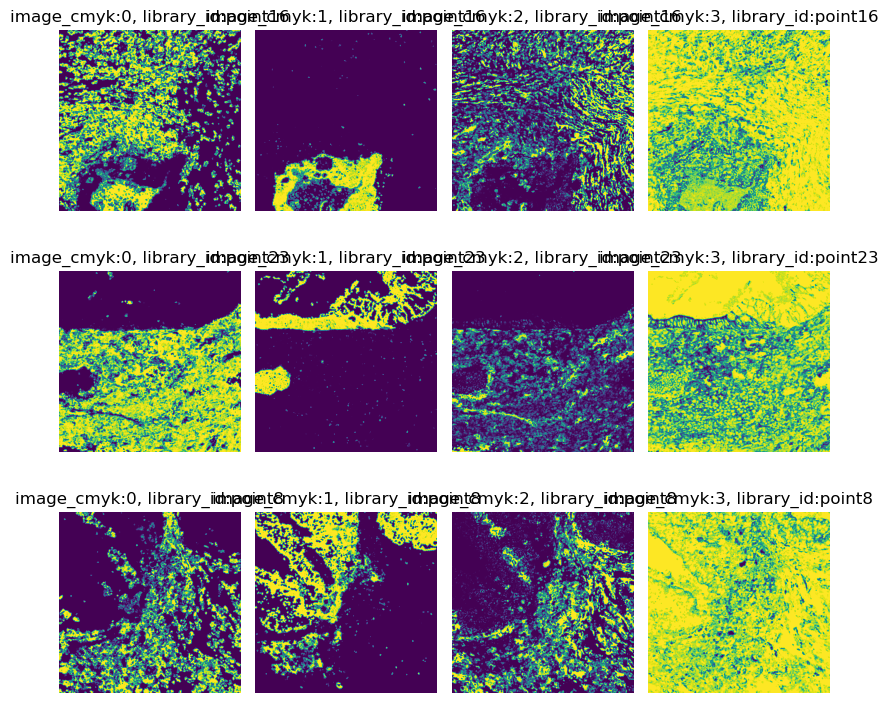

In [8]:

def rgb2cmyk(arr):
    """Convert arr from RGB to CMYK color space."""
    R = arr[..., 0] / 255
    G = arr[..., 1] / 255
    B = arr[..., 2] / 255
    K = 1 - (np.max(arr, axis=-1) / 255)
    C = (1 - R - K) / (1 - K + np.finfo(float).eps)  # avoid division by 0
    M = (1 - G - K) / (1 - K + np.finfo(float).eps)
    Y = (1 - B - K) / (1 - K + np.finfo(float).eps)
    return np.stack([C, M, Y, K], axis=3)


img.apply(rgb2cmyk, layer="image", new_layer="image_cmyk", copy=False)
img.show("image_cmyk", channelwise=True)

Extract per-cell mean intensity
-------------------------------
Now that we have disentangled the individual channels, let use use the provided segmentation mask
to extract per-cell mean intensities.

By default, the `segmentation` feature extractor extracts information using all segments (cells)
in the current crop.
As we would like to only get information of the segment (cell) in the center of the current crop,
let us use a `custom` feature extractor.

Fist, define a custom feature extraction function. This function needs to get the segmentation mask
and the original image as input.
We will achieve this by passing an ``additional_layers`` argument to the `custom` feature extractor.
This special argument will pass the values of every layer in `additional_layers`
to the custom feature extraction function.

In [9]:

def segmentation_image_intensity(arr, image_cmyk):
    """
    Calculate per-channel mean intensity of the center segment.

    arr: the segmentation
    image_cmyk: the raw image values
    """
    import skimage.measure

    # the center of the segmentation mask contains the current label
    # use that to calculate the mask
    s = arr.shape[0]
    mask = (arr == arr[s // 2, s // 2, 0, 0]).astype(int)
    # use skimage.measure.regionprops to get the intensity per channel
    features = []
    for c in range(image_cmyk.shape[-1]):
        feature = skimage.measure.regionprops_table(
            np.squeeze(mask),  # skimage needs 3d or 2d images, so squeeze excess dims
            intensity_image=np.squeeze(image_cmyk[:, :, :, c]),
            properties=["mean_intensity"],
        )["mean_intensity"][0]
        features.append(feature)
    return features


Now, use {func}`squidpy.im.calculate_image_features` with the `custom` feature extractor,
specifying the function (``func``) to use, and the additional layers (``additional_layers``)
to pass to the function.
We will use ``spot_scale = 10`` to ensure that we also cover big segments fully by one crop.

In [10]:
sq.im.calculate_image_features(
    adata,
    img,
    library_id="library_id",
    features="custom",
    spot_scale=10,
    layer="segmentation",
    features_kwargs={"custom": {"func": segmentation_image_intensity, "additional_layers": ["image_cmyk"]}},
)

100%|██████████| 3309/3309 [00:26<00:00, 126.91/s]


The resulting features are stored in ``adata.obs['img_features']``,
with channel 0 representing `145_CD45`, channel 1 `174_CK`, and channel 2 `113_vimentin`.

In [11]:
adata.obsm["img_features"]

,segmentation_image_intensity_0,segmentation_image_intensity_1,segmentation_image_intensity_2,segmentation_image_intensity_3
3034-0,0.000000,0.995041,0.010664,0.492503
3035-0,0.000049,0.884839,0.042991,0.713101
3036-0,0.680350,0.000235,0.222640,0.948284
3037-0,0.813055,0.000000,0.173941,0.790169
3038-0,0.420203,0.015063,0.486171,0.709584
...,...,...,...,...
47342-2,0.000000,0.000000,0.696113,0.855720
47343-2,0.441017,0.000000,0.587986,0.941870
47344-2,0.639157,0.000000,0.344870,0.858989
47345-2,0.196760,0.000000,0.612479,0.855991


As described in {cite}`hartmann2020multiplexed`, let us transformed using an
inverse hyperbolic sine (`arcsinh`) co-factor of 0.05, to allow us to compare
the computed mean intensities with the values contained in `adata`.

In [12]:
adata.obsm["img_features_transformed"] = np.arcsinh(adata.obsm["img_features"] / 0.05)

Now, let's visualize the result:

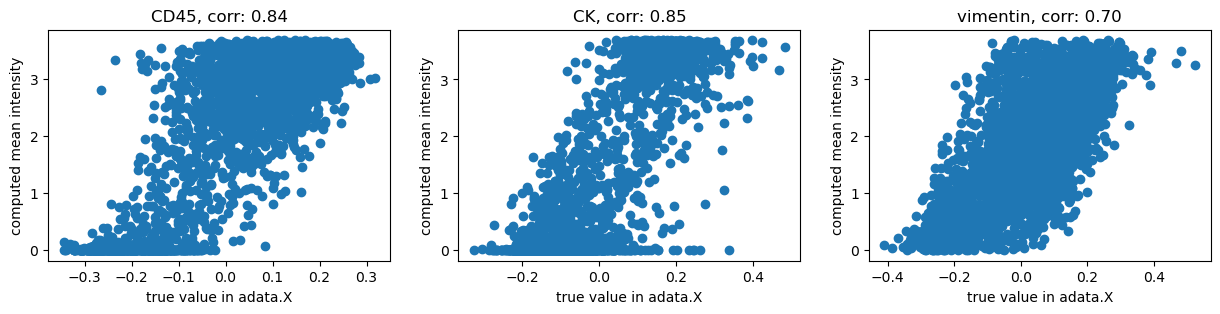

In [13]:
channels = ["CD45", "CK", "vimentin"]

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for i, ax in enumerate(axes):
    X = np.array(adata[:, channels[i]].X.todense())[:, 0]
    Y = adata.obsm["img_features_transformed"][f"segmentation_image_intensity_{i}"]
    ax.scatter(X, Y)
    ax.set_xlabel("true value in adata.X")
    ax.set_ylabel("computed mean intensity")
    corr = np.corrcoef(X, Y)[1, 0]
    ax.set_title(f"{channels[i]}, corr: {corr:.2f}")

We get high correlations between the original values and our computation using Squidpy.
The remaining differences are probably due to more pre-processing applied by
the authors of {cite}`hartmann2020multiplexed`.

In this tutorial we have shown how to pre-process imaging data to extract per-cell
counts / mean intensities using Squidpy.
Of course it is also possible to apply spatial statistics functions provided by the
{mod}`squidpy.gr` module to MIBI-TOF data.
For examples of this, please see our other Analysis tutorials, e.g.
{doc}`tutorials/tutorial_seqfish.py`.